In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray
import cmocean.cm as cmo

### Read in low res data

In [2]:
file_mo = '/Users/hetl729/Data/mpaso.hist.am.timeSeriesStatsMonthly.0026-01-01.nc'
file_grd = '/Users/hetl729/Data/oEC60to30v3.restartFrom_anvilG.200927.nc'
ds = xarray.open_dataset(file_mo)
dsg = xarray.open_dataset(file_grd)

# Plotting function

This function could be the basis of an xarray plot accessor. Some issues:

 * This function does not handle the seam (here at 0˚ lon)
 * Only works for cell properties. 
 * Region selection could be improved. Best to pull this logic out into a grid object.
 * Region selection and plotting are both fairly fast.
 * Plotting on a projection is slow.

In [3]:
def plotCell(dsg, prop, window, ax,
             cmap=None, cmin=None, cmax=None, 
             edgefactor=1.0):
    '''return polygon (no axis provided) or mappable (if axis provided) after plotting
    
    Inputs
    ------
    dsg          MPAS-O dataset with grid Vertex information.
    prop         A dataarray on Cell-center points.
    window       A sequence of [lon_min, lon_max, lat_min, lat_max] in the units
                 of lon and lat in the simulation.
    ax           An axis object on which to plot the polygons, a mappable object is returned.
                 If axis is explicitly set to `None`, the Polygon collection is returned.
    cmin, cmax   The color limits of the color mapping. If none, the min and max of the 
                 property within the window are used.
    edgefactor   The multiplier by which to 'darken' the edges. Default of 1 is used when the edge
                 and face have the same color. Less than one for darker shades. Zero for black.
    '''
    lons = dsg.lonVertex.values[dsg.verticesOnCell-1] * 180.0 / np.pi - 360
    lats = dsg.latVertex.values[dsg.verticesOnCell-1] * 180.0 / np.pi

    inside_vert = (lons>window[0]) * (lons<window[1]) * \
                  (lats>window[2]) * (lats<window[3])
    inside_vert[dsg.verticesOnCell == 0] = True
    idx = np.all(inside_vert, axis=1)
    
    if cmin is None:
        cmin = prop[idx].min().values
    if cmax is None:
        cmax = prop[idx].max().values
    if cmap is None:
        cmap = plt.cm.viridis
    
    norm = plt.matplotlib.colors.Normalize(cmin, cmax)

    facecolors = cmap(norm(prop.values))
    edgecolors = facecolors.copy()
    edgecolors[:,:3] *= edgefactor

    verts = np.dstack((lons[idx], lats[idx]))
    nverts = np.sum(dsg.verticesOnCell != 0, axis=1)[idx].values
    verts = [vert[:n] for vert, n in zip(verts, nverts)]
    
    polys = plt.matplotlib.collections.PolyCollection(verts,
                                                      facecolors=facecolors[idx], 
                                                      edgecolors=edgecolors[idx],
                                                      transform=ccrs.PlateCarree()
                                                     )
    
    if ax is None:
        return polys
    else:
        ax.add_collection(polys)
    
    return plt.matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)


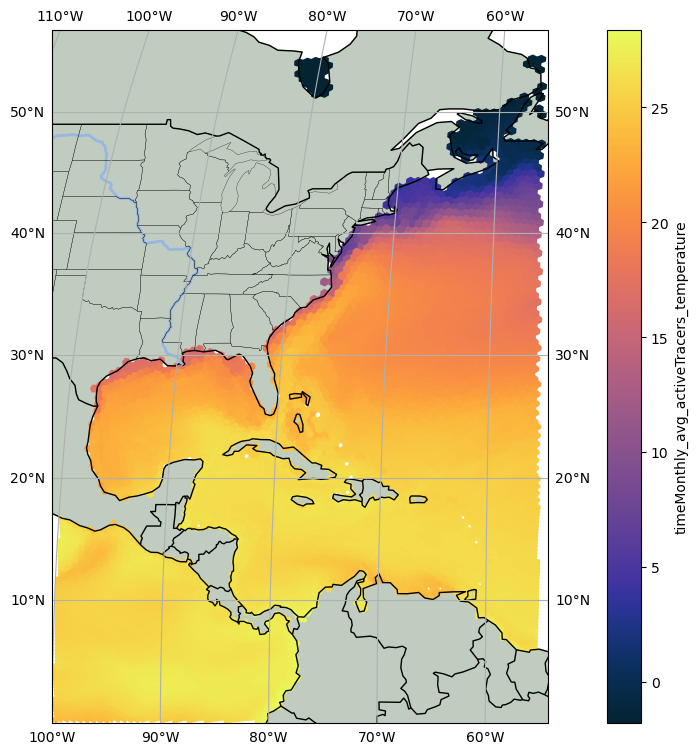

In [4]:
proj = ccrs.Robinson(-50)
window = np.array([-100, -55, 0, 55])
prop = ds['timeMonthly_avg_activeTracers_temperature'][0, :, 0]
cmap = cmo.thermal

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection=proj)
cb = plotCell(dsg, prop, window, ax, cmap=cmap)

ax.add_feature(cfeature.LAND, facecolor=(0.75, 0.8, 0.75))
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.RIVERS, lw=2)
ax.add_feature(cfeature.STATES, lw=0.2)

plt.colorbar(cb, ax=ax).set_label(prop.name)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.set_extent(window)

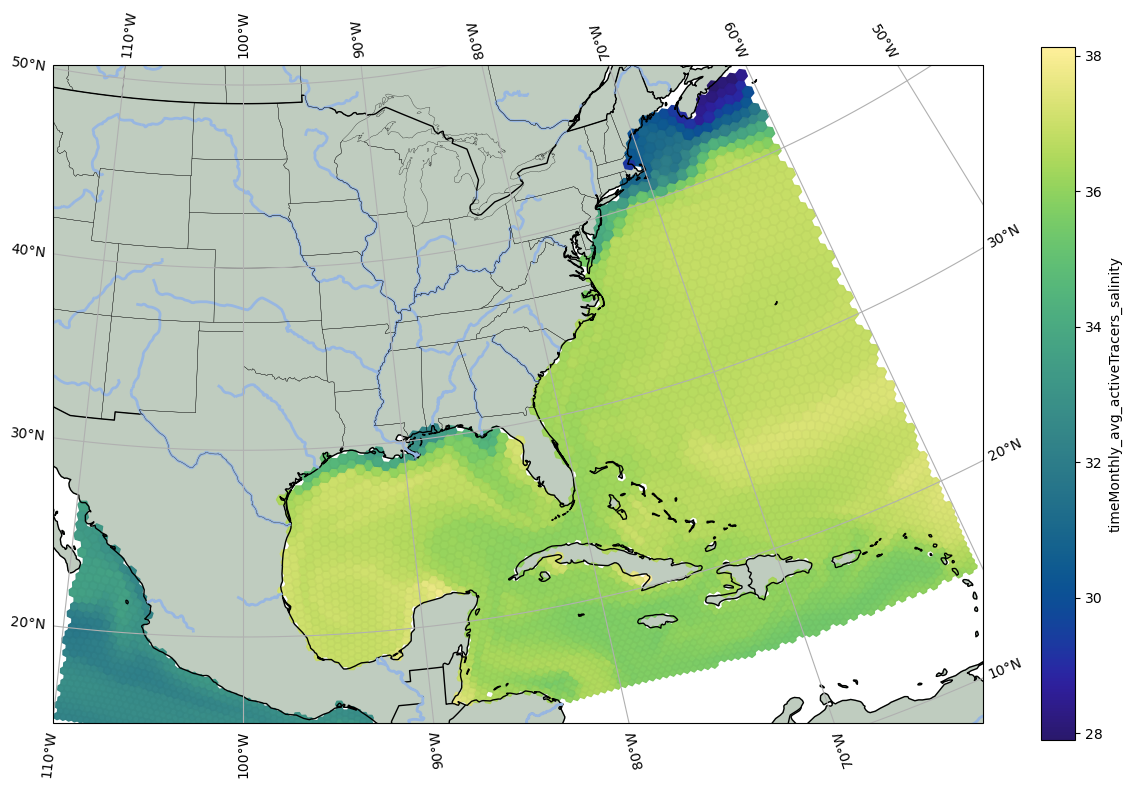

In [5]:
proj = ccrs.LambertConformal(-100, 30)
window = np.array([-110, -60, 15, 45])
prop = ds['timeMonthly_avg_activeTracers_salinity'][0, :, 0]
cmap = cmo.haline

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection=proj)
cb = plotCell(dsg, prop, window, ax, cmap=cmap, edgefactor=0.97)

ax.add_feature(cfeature.LAND, facecolor=(0.75, 0.8, 0.75))
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.RIVERS, lw=2)
ax.add_feature(cfeature.STATES, lw=0.2)

plt.colorbar(cb, ax=ax).set_label(prop.name)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.set_extent(window)

In [6]:
dsg

<xarray.Dataset>
Dimensions:                        (nCells: 235160, nEdges: 714274,
                                    nVertices: 478835, TWO: 2, maxEdges: 7,
                                    maxEdges2: 14, vertexDegree: 3,
                                    nVertLevels: 60, Time: 1,
                                    nVertLevelsP1: 61, nForcingGroupsMax: 4)
Dimensions without coordinates: nCells, nEdges, nVertices, TWO, maxEdges,
                                maxEdges2, vertexDegree, nVertLevels, Time,
                                nVertLevelsP1, nForcingGroupsMax
Data variables: (12/73)
    latCell                        (nCells) float64 ...
    lonCell                        (nCells) float64 ...
    xCell                          (nCells) float64 ...
    yCell                          (nCells) float64 ...
    zCell                          (nCells) float64 ...
    indexToCellID                  (nCells) int32 ...
    ...                             ...
    accumulatedLandIceFrazilMass   (Time, nCells) float64 ...
    frazilSurfacePressure          (Time, nCells) float64 ...
    filteredSSHGradientZonal       (Time, nCells) float64 ...
    filteredSSHGradientMeridional  (Time, nCells) float64 ...
    forcingGroupNames              (Time, nForcingGroupsMax) |S64 ...
    forcingGroupRestartTimes       (Time, nForcingGroupsMax) |S64 ...
Attributes: (12/1149)
    on_a_sphere:                                                     YES
    sphere_radius:                                                   6371229.0
    model_name:                                                      mpas
    core_name:                                                       ocean
    history:                                                         Sun Sep ...
    source:                                                          MPAS
    ...                                                              ...
    config_rx1_zstar_weight:                                         1.0
    config_rx1_horiz_smooth_open_ocean_cells:                        20
    config_rx1_min_levels:                                           3
    config_rx1_min_layer_thickness:                                  1.0
    file_id:                                                         yhiq7ay4ez
    NCO:                                                             netCDF O...